## Pizza vs Clock Experiment (Transformer)

### Setup

In [1]:
# Import stuff
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import numpy as np
import einops
import tqdm

import random
import time

from pathlib import Path
import pickle
import os

import matplotlib.pyplot as plt
import plotly.express as px
import plotly.io as pio
pio.renderers.default = "colab"
import plotly.graph_objects as go

from torch.utils.data import DataLoader

from functools import *
import pandas as pd
import gc

# import comet_ml
import itertools
# import comet_ml
import wandb
import itertools
class HookPoint(nn.Module):
    def __init__(self):
        super().__init__()
        self.fwd_hooks = []
        self.bwd_hooks = []
    def give_name(self, name):
        self.name = name
    def add_hook(self, hook, dir='fwd'):
        def full_hook(module, module_input, module_output):
            return hook(module_output, name=self.name)
        if dir=='fwd':
            handle = self.register_forward_hook(full_hook)
            self.fwd_hooks.append(handle)
        elif dir=='bwd':
            handle = self.register_backward_hook(full_hook)
            self.bwd_hooks.append(handle)
        else:
            raise ValueError(f"Invalid direction {dir}")
    def remove_hooks(self, dir='fwd'):
        if (dir=='fwd') or (dir=='both'):
            for hook in self.fwd_hooks:
                hook.remove()
            self.fwd_hooks = []
        if (dir=='bwd') or (dir=='both'):
            for hook in self.bwd_hooks:
                hook.remove()
            self.bwd_hooks = []
        if dir not in ['fwd', 'bwd', 'both']:
            raise ValueError(f"Invalid direction {dir}")
    def forward(self, x):
        return x

class Embed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_E = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_model))
    def forward(self, x):
        return torch.einsum('dbp -> bpd', self.W_E[:, x])

class Unembed(nn.Module):
    def __init__(self, d_vocab, d_model):
        super().__init__()
        self.W_U = nn.Parameter(torch.randn(d_model, d_vocab)/np.sqrt(d_vocab))
    def forward(self, x):
        return (x @ self.W_U)

# Positional Embeddings
class PosEmbed(nn.Module):
    def __init__(self, max_ctx, d_model):
        super().__init__()
        self.W_pos = nn.Parameter(torch.randn(max_ctx, d_model)/np.sqrt(d_model))
    def forward(self, x):
        return x+self.W_pos[:x.shape[-2]]

# Attention
class Attention(nn.Module):
    def __init__(self, d_model, num_heads, d_head, n_ctx, attn_coeff):
        super().__init__()
        self.W_K = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_Q = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_V = nn.Parameter(torch.randn(num_heads, d_head, d_model)/np.sqrt(d_model))
        self.W_O = nn.Parameter(torch.randn(d_model, d_head * num_heads)/np.sqrt(d_model))
        self.attn_coeff = attn_coeff
        self.register_buffer('mask', torch.tril(torch.ones((n_ctx, n_ctx))))
        self.d_head = d_head
        self.hook_k = HookPoint()
        self.hook_q = HookPoint()
        self.hook_v = HookPoint()
        self.hook_z = HookPoint()
        self.hook_attn = HookPoint()
        self.hook_attn_pre = HookPoint()

    def forward(self, x):
        k = self.hook_k(torch.einsum('ihd,bpd->biph', self.W_K, x))
        q = self.hook_q(torch.einsum('ihd,bpd->biph', self.W_Q, x))
        v = self.hook_v(torch.einsum('ihd,bpd->biph', self.W_V, x))
        attn_scores_pre = torch.einsum('biph,biqh->biqp', k, q)
        attn_scores_masked =attn_scores_pre
        attn_matrix = self.hook_attn(
            F.softmax(self.hook_attn_pre(attn_scores_masked/np.sqrt(self.d_head)), dim=-1)\
            *self.attn_coeff+(1-self.attn_coeff))
        z = self.hook_z(torch.einsum('biph,biqp->biqh', v, attn_matrix))
        z_flat = einops.rearrange(z, 'b i q h -> b q (i h)')
        out = torch.einsum('df,bqf->bqd', self.W_O, z_flat)
        return out

class MLP(nn.Module):
    def __init__(self, d_model, d_mlp, act_type):
        super().__init__()
        self.W_in = nn.Parameter(torch.randn(d_mlp, d_model)/np.sqrt(d_mlp))
        self.b_in = nn.Parameter(torch.zeros(d_mlp))
        self.W_out = nn.Parameter(torch.randn(d_model, d_mlp)/np.sqrt(d_model))
        self.b_out = nn.Parameter(torch.zeros(d_model))
        self.act_type = act_type
        # self.ln = LayerNorm(d_mlp, model=self.model)
        self.hook_pre = HookPoint()
        self.hook_post = HookPoint()
        assert act_type in ['ReLU', 'GeLU', 'Tanh']
        
    def forward(self, x):
        x = self.hook_pre(torch.einsum('md,bpd->bpm', self.W_in, x) + self.b_in)
        if self.act_type=='ReLU':
            x = F.relu(x)
        elif self.act_type=='GeLU':
            x = F.gelu(x)
        elif self.act_type=='Tanh':
            x = F.tanh(x)
        x = self.hook_post(x)
#        return x
        x = torch.einsum('dm,bpm->bpd', self.W_out, x) + self.b_out
        return x

# Transformer Block
class TransformerBlock(nn.Module):
    def __init__(self, d_model, d_head, num_heads, n_ctx, act_type, attn_coeff):
        super().__init__()
        self.attn = Attention(d_model, num_heads, d_head, n_ctx, attn_coeff=attn_coeff)
        self.mlp = MLP(d_model, d_model*4,act_type)
        self.hook_attn_out = HookPoint()
        self.hook_mlp_out = HookPoint()
        self.hook_resid_pre = HookPoint()
        self.hook_resid_mid = HookPoint()
        self.hook_resid_post = HookPoint()
    
    def forward(self, x):
        x = self.hook_resid_mid(x + self.hook_attn_out(self.attn(self.hook_resid_pre(x))))
        x = self.hook_resid_post(x + self.hook_mlp_out(self.mlp(x)))
        return x

# Full transformer
class Transformer(nn.Module):
    def __init__(self, num_layers, d_vocab, d_model, d_head, num_heads, n_ctx, act_type, attn_coeff, use_cache=False, use_ln=True):
        super().__init__()
        assert 0<=attn_coeff<=1
        #print('parameters', num_layers, d_vocab, d_model, d_head, num_heads, n_ctx, act_type, attn_coeff, use_cache, use_ln)
        self.cache = {}
        self.use_cache = use_cache

        self.embed = Embed(d_vocab, d_model)
        self.pos_embed = PosEmbed(n_ctx, d_model)
        self.unembed = Unembed(d_vocab, d_model)
        self.use_ln = use_ln
        self.blocks = nn.ModuleList([TransformerBlock(d_model, d_head, num_heads, n_ctx, act_type, attn_coeff) for i in range(num_layers)])

        for name, module in self.named_modules():
            if type(module)==HookPoint:
                module.give_name(name)
    
    def forward(self, x):
        x = self.embed(x)
        x = self.pos_embed(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.unembed(x)
        return x
    def forward_h(self, x):
        x = self.embed(x)
        tmp=x
        x = self.pos_embed(x)
        for blk in self.blocks:
            x = blk(x)
        x = self.unembed(x)
        return tmp,x
    def forward_b(self, x):
        x = self.embed(x)
        tmp=x
        x = self.pos_embed(x)
        for blk in self.blocks:
            x = blk(x)
        return x

    def set_use_cache(self, use_cache):
        self.use_cache = use_cache
    
    def hook_points(self):
        return [module for name, module in self.named_modules() if 'hook' in name]

    def remove_all_hooks(self):
        for hp in self.hook_points():
            hp.remove_hooks('fwd')
            hp.remove_hooks('bwd')
    
    def cache_all(self, cache, incl_bwd=False):
        # Caches all activations wrapped in a HookPoint
        def save_hook(tensor, name):
            cache[name] = tensor.detach()
        def save_hook_back(tensor, name):
            cache[name+'_grad'] = tensor[0].detach()
        for hp in self.hook_points():
            hp.add_hook(save_hook, 'fwd')
            if incl_bwd:
                hp.add_hook(save_hook_back, 'bwd')
    
    def parameters_norm(self):
        # Returns the l2 norm of all parameters
        return sum([torch.sum(p*p).item() for p in self.parameters()])**0.5
    
    def l2_norm(self):
        # Returns the l2 norm of all parameters
        return sum([torch.sum(p*p) for p in self.parameters()])
    
    def parameters_flattened(self):
        # Returns all parameters as a single tensor
        return torch.cat([p.view(-1) for p in self.parameters()]).detach().cpu().numpy()
#DEVICE='cuda'
DEVICE='cpu'
print(f'Running on {DEVICE}')
class MyAddDataSet(torch.utils.data.Dataset):
    def __init__(self, func, C, diff_vocab=False, eqn_sign=False):
        self.func = func
        dim = 2
        self.dim = dim
        self.C = C
        self.inputs = []
        self.outputs = []
        self.vocab=C
        if diff_vocab:
            self.vocab*=2
        if eqn_sign:
            self.vocab+=1
            self.dim+=1
        self.vocab_out=0
        for p in range(C**dim):
            x = np.unravel_index(p, (C,)*dim)
            o=self.func(x)
            s=[x[0],x[1]]
            if diff_vocab:
                s[1]+=C
            if eqn_sign:
                s.append(self.vocab-1)
            self.inputs.append(s)
            self.outputs.append(o)
            self.vocab_out=max(self.vocab_out, o+1)
        if self.vocab_out!=C:
            print(f'warning {self.vocab_out=} neq to {C=}')
        self.inputs = torch.tensor(self.inputs, dtype=torch.long, device=DEVICE)
        self.outputs = torch.tensor(self.outputs, dtype=torch.long, device=DEVICE)
        #print(self.inputs,self.outputs)
    def __len__(self):
        return len(self.outputs)
    def __getitem__(self, idx):
        return self.inputs[idx], self.outputs[idx]
    
def cross_entropy_high_precision(logits, labels):
    # Shapes: batch x vocab, batch
    # Cast logits to float64 because log_softmax has a float32 underflow on overly 
    # confident data and can only return multiples of 1.2e-7 (the smallest float x
    # such that 1+x is different from 1 in float32). This leads to loss spikes 
    # and dodgy gradients
    logprobs = F.log_softmax(logits.to(torch.float64), dim=-1)
    prediction_logprobs = torch.gather(logprobs, index=labels[:, None], dim=-1)
    loss = -torch.mean(prediction_logprobs)
    return loss
def run_experiment(config, silent=False):
    exp_name=config['name']
    if not silent:
        print('parsing func',config['funcs'])
    config['func']=eval(config['funcs'])
    full_dataset = MyAddDataSet(func=config['func'],C=config['C'],diff_vocab=config['diff_vocab'],eqn_sign=config['eqn_sign'])
    model = Transformer(
        num_layers=config.get('n_layers',1),
        num_heads=config['n_heads'],
        d_model=config['d_model'],
        d_head=config.get('d_head',config['d_model']//config['n_heads']),
        attn_coeff=config['attn_coeff'],
        d_vocab=full_dataset.vocab,
#        attention_dir=config.get('attention_dir','bidirectional'),
        act_type=config.get('act_fn','relu'),
        n_ctx=full_dataset.dim,
#        normalization_type=None,
    )
    model.to(DEVICE)
    train_size = int(config['frac'] * len(full_dataset))
    test_size = len(full_dataset) - train_size
    train_dataset, test_dataset = torch.utils.data.random_split(full_dataset, [train_size, test_size])
    if not silent:
        print('random split',len(train_dataset),len(test_dataset))
    batch_size = config.get('batch_size',len(full_dataset))
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=False)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    opt = optim.AdamW(model.parameters(),lr=config.get('lr',1e-3),weight_decay=config.get('weight_decay',1e-4),betas=(0.9,0.98))
    scheduler = optim.lr_scheduler.LambdaLR(opt, lambda step: min(step/10, 1)) # 10 epoch warmup
    if not silent:
        print(config.get('lr',1e-3),config.get('weight_decay',1e-4))
        print(opt,scheduler)
    losses=[]
    accs=[]
    losses_val=[]
    accs_val=[]
    norms=[]
    loss_val=10
    acc_val=0
    stop=None
    best_train_acc=0.
    best_test_acc=0.
    perfect_train_time=None
    perfect_test_time=None
    pbar = range(config.get('epoch',10000))
    if not silent:
        pbar=tqdm.tqdm(pbar)
    gaps=[]
    early_stop_a=2
    early_stop_b=1
    if config.get('early_stop',None) is not None:
        early_stop_a, early_stop_b = config['early_stop']
    early_stop_timer=0
    #model.train()
    run = None#wandb.init(reinit=True,config=config,project='modadd_new')#,settings=wandb.Settings(start_method="spawn"))
    try:
        for i in pbar:
            def evaluation():
                nonlocal best_test_acc
                nonlocal perfect_test_time
                nonlocal early_stop_timer
                nonlocal early_stop_a
                nonlocal early_stop_b
                # evaluate on test set, return loss and accuracy
                # with torch.inference_mode():
                    #model.eval()
                losses_eval=[]
                accs_eval=[]
                for inp,ans in test_loader:
                    # print(inp.shape)
                    out = model(inp)[:,-1,:]
                    loss = cross_entropy_high_precision(out,ans)
                    acc = torch.sum((out.argmax(dim=1)==ans).float())/len(ans)
                    # print(inp,'test',out.argmax(dim=1),ans)
#                    acc = (out.argmax(dim=1)==ans).float().mean()
                    losses_eval.append(loss.item())
                    accs_eval.append(acc.item())
                    # print(loss,acc)
                #print(losses_eval,accs_eval)
                eval_loss, eval_acc = np.mean(losses_eval), np.mean(accs_eval)
                best_test_acc = max(best_test_acc, eval_acc)
                if eval_acc==1. and perfect_test_time is None:
                    perfect_test_time = i
                if eval_acc>=early_stop_a:
                    early_stop_timer+=1
                else:
                    early_stop_timer=0
                #print(eval_loss,eval_acc)
                return eval_loss, eval_acc
            if early_stop_timer>=early_stop_b:
                break
            for inp,ans in train_loader:
                #print(inp.shape,inp.dtype)
                # print(inp,'train')
                #print(len(inp))
                #model.train()
                out = model(inp)[:,-1,:]
                loss = cross_entropy_high_precision(out,ans)
                loss_val, acc_val = evaluation()
                #print(loss_val,acc_val)
                loss.backward()
                # clip gradients
                #if config.get('clip',None) is not None:
                #    nn.utils.clip_grad_norm_(model.parameters(), config['clip'])
                opt.step()
                scheduler.step()
                opt.zero_grad()
                acc = (out.argmax(dim=1)==ans).float().mean()
                norm = sum([torch.sum(p*p).item() for p in model.parameters()])**0.5
                #sum(p.norm()**2 for p in model.parameters()).sqrt().item()
                losses.append(loss.item())
                accs.append(acc.item())
                losses_val.append(loss_val)
                accs_val.append(acc_val)
                norms.append(norm)

                best_train_acc=max(best_train_acc,acc.item())
                if acc.item()==1. and perfect_train_time is None:
                    perfect_train_time = i
                gaps.append(best_train_acc-best_test_acc)
                if pbar is tqdm.tqdm:
                    pbar.set_description(f"loss: {loss.item():.3f}, accm: {best_train_acc:.3f}, vloss: {loss_val:.3f}, vaccm: {best_test_acc:.3f}, norm: {norm:.3f}, acc: {acc.item():.3f}, vacc: {acc_val:.3f}")
                #print(f"loss: {loss.item():.3f}, accm: {best_train_acc:.3f}, vloss: {loss_val:.3f}, vaccm: {best_test_acc:.3f}, norm: {norm:.3f}, acc: {acc.item():.3f}, vacc: {acc_val:.3f}")
                if run:
                    run.log({'training_loss': loss.item(),
                    'validation_loss': loss_val,
                    'training_accuracy': acc.item(),
                    'validation_accuracy': acc_val,
                    'parameter_norm': norm,
                    'best_train_accuracy': best_train_acc,
                    'best_test_accuracy': best_test_acc,
                    'generalization_gap': best_train_acc-best_test_acc,
                    'generalization_delay1': sum(gaps)})
    except KeyboardInterrupt:
        print('Keyboard interrupt. Gracefully exiting...')
        pass
    if not silent:
        print('Finished.')
    generalization_gap=best_train_acc-best_test_acc
    generalization_delay1=sum(gaps)
    generalization_delay2=sum(max(t-(best_train_acc-best_test_acc),0) for t in gaps)
    if run:
        run.summary["generalization_delay2"] = generalization_delay2
    # run.finish()
    return dict(
        losses=losses,
        accs=accs,
        losses_val=losses_val,
        accs_val=accs_val,
        norms=norms,
        model=model,
        config=config,
        generalization_gap=generalization_gap,
        generalization_delay1=generalization_delay1,
        generalization_delay2=generalization_delay2,
        best_train_acc=best_train_acc,
        best_test_acc=best_test_acc,
        perfect_train_time=perfect_train_time,
        perfect_test_time=perfect_test_time,
        dataset = full_dataset,
        run=run
    )

Running on cpu


### Load Trained Model

In [2]:
# Here you can specify the model to load
modelA='p99zdpze5l'
modelB='l8k1hzciux'
runid=modelA
import json
with open(f'save/config_{runid}.json','r') as f:
    config=json.load(f)
model_file=f'save/model_{runid}.pt'

In [3]:
C=59
print(config)
config.setdefault('diff_vocab',False)
config.setdefault('eqn_sign',False)
config['epoch']=2
result_modadd=run_experiment(config, True)
model=result_modadd['model']
dataset = result_modadd['dataset']
dataloader = torch.utils.data.DataLoader(dataset, batch_size=C*C)
model.load_state_dict(torch.load(model_file,map_location=DEVICE))

{'name': 'modadd_59', 'funcs': 'lambda x: (x[0]+x[1])%59', 'C': 59, 'n_heads': 4, 'd_model': 128, 'n_layers': 1, 'attention_dir': 'casual', 'act_fn': 'ReLU', 'epoch': 20000, 'batch_size': 3481, 'lr': 0.001, 'weight_decay': 2.0, 'frac': 0.8, 'attn_coeff': 0, 'runid': 'p99zdpze5l', 'diff_vocab': 0, 'eqn_sign': 0, 'func': None}


<All keys matched successfully>

In [4]:
# l2-norm of model?
print(f"l2-norm of model: {model.parameters_norm():.3f}")

l2-norm of model: 22.854


### Principal Component Visualization

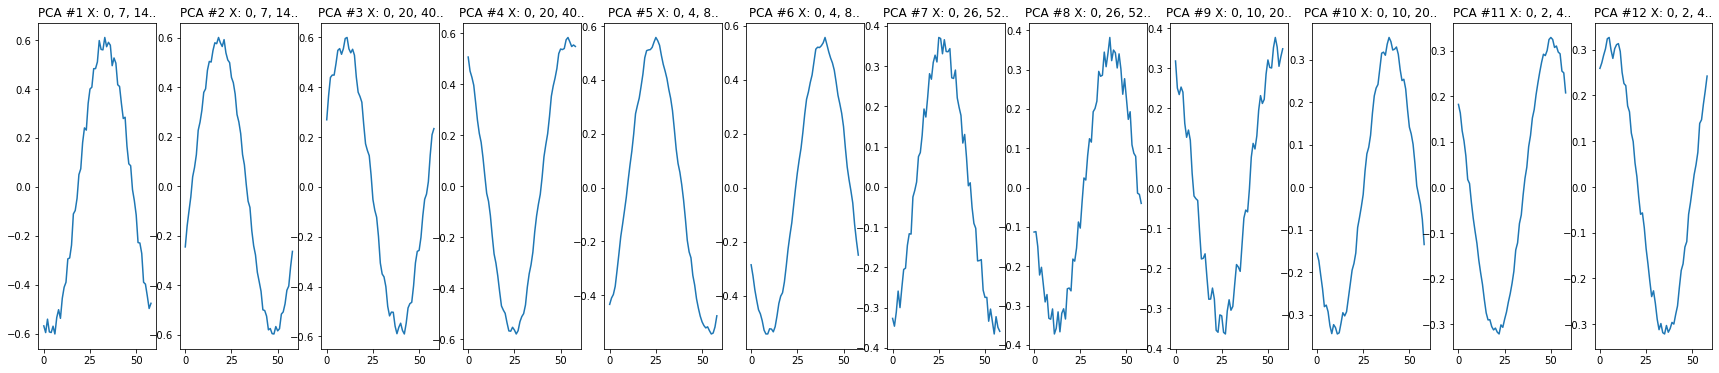

In [5]:
model.load_state_dict(torch.load(model_file,map_location=DEVICE))
# ok, now let's manipulate the embedding weights
we=model.embed.W_E.T
# now use scikit PCA to reduce the dimensionality of the embedding
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
we2=pca.fit_transform(we.detach().cpu().numpy())
plt.figure(figsize=(30,6))
import math
pi=math.pi
for ix in range(12):
    vs=we2[:,ix]
    tt=[]
    for i in range(1,59):
        vv=[vs[t*i%59] for t in range(59)]
        sa=sum(vv[t]*(math.cos(2*pi/59*t)+1j*math.sin(2*pi/59*t)) for t in range(59))
        sa=-abs(sa)
#        sa=sum(abs(p-q) for p,q in zip(vv,vv[1:]))
        tt.append((sa,i))
    tt.sort()
    plt.subplot(1,12,ix+1)
    i=tt[0][1]
    i=min(i,59-i)
    v=[vs[t*i%59] for t in range(59)]
    plt.title(f'PCA #{ix+1} X: 0, {i}, {2*i%59}..')
    plt.plot(v)

### Distance Irrelevance

Distance Irrelevance 0.17173645661473538


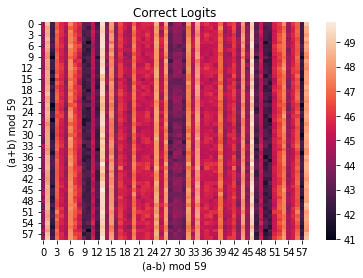

In [6]:
model=result_modadd['model']
model.load_state_dict(torch.load(model_file,map_location=DEVICE))
dataset = result_modadd['dataset']
dataloader = torch.utils.data.DataLoader(dataset, batch_size=C*C)
model = result_modadd['model']
oo=[[0]*C for _ in range(C)]
for x,y in dataloader:
    #print(x)
    with torch.inference_mode():
        model.eval()
        model.remove_all_hooks()
        o=model(x)[:,-1,:]
        o0=o[list(range(len(x))),y]
        o0=o0.cpu()
        x=x.cpu()
        for p,q in zip(o0,x):
            A,B=int(q[0].item()),int(q[1].item())
            oo[(A+B)%C][(A-B)%C]=p.item()
oo=np.array(oo)
import seaborn as sns
dd=np.mean(np.std(oo,axis=0))/np.std(oo.flatten())
sns.heatmap(np.array(oo))
plt.xlabel(f'(a-b) mod {C}')
plt.ylabel(f'(a+b) mod {C}')
plt.title('Correct Logits')
print('Distance Irrelevance',dd)

### Gradient Symmetricity

In [7]:
model.load_state_dict(torch.load(model_file,map_location='cpu'))
# we=model.embed.W_E.T
# from sklearn.decomposition import PCA
# pca = PCA(n_components=20)
# we2=pca.fit_transform(we.detach().cpu().numpy())
oc=None
tt=0
xs=[(a,b,c) for a in range(C) for b in range(C) for c in range(C)]
random.Random(42).shuffle(xs)
xs=xs[:100]
for abc in xs:
    a,b,c=abc
    x=torch.tensor([[a,b]],device='cpu')
    t,o0=model.forward_h(x)
    model.zero_grad()
    #print(a,b,c)
    model.remove_all_hooks()
    o=o0[0,-1,:]
    t.retain_grad()
    o[c].backward(retain_graph=True)
    tg=t.grad[0].detach().cpu().numpy()
    #tt+=tg[0][0]
    dp=np.sum(tg[0]*tg[1])/np.sqrt(np.sum(tg[0]**2))/np.sqrt(np.sum(tg[1]**2))
    tt+=dp
print('Gradient Symmetricity',tt/len(xs))

Gradient Symmetricity 0.9936651682853699


### Circularity

In [8]:
model.load_state_dict(torch.load(model_file,map_location=DEVICE))
we=model.embed.W_E.T
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
import math
we2=pca.fit_transform(we.detach().cpu().numpy())
def ang(x):
    return math.cos(x)+math.sin(x)*1j
rst=0
first_k=4
for ix in range(first_k):
    vs=we2[:,ix]*1
    vs=vs/np.sqrt(np.sum(vs*vs))/math.sqrt(59)
    tt=[]
    for i in range(1,59):
        vv=[vs[t*i%59] for t in range(59)]
        sa=sum(vv[t]*ang(2*math.pi*t/59) for t in range(59))
        tt.append((-abs(sa)**2*2,i))
    tt.sort()
    i=tt[0][1]
    rst+=max(min(-tt[0][0],1.),0.)
    i=min(i,59-i)
    v=[vs[t*i%59] for t in range(59)]
rst/=first_k
print('Circularity',rst)

Circularity 0.9978184479185687


### Attention Pattern

In [9]:
# cache the attention
model.load_state_dict(torch.load(model_file,map_location=DEVICE))
for x,y in dataloader:
    with torch.inference_mode():
        model.remove_all_hooks()
        ch={}
        model.cache_all(ch)
        model.eval()
        o=model(x)[:,-1,:]
        model.remove_all_hooks()
cached_attn=ch['blocks.0.attn.hook_attn']

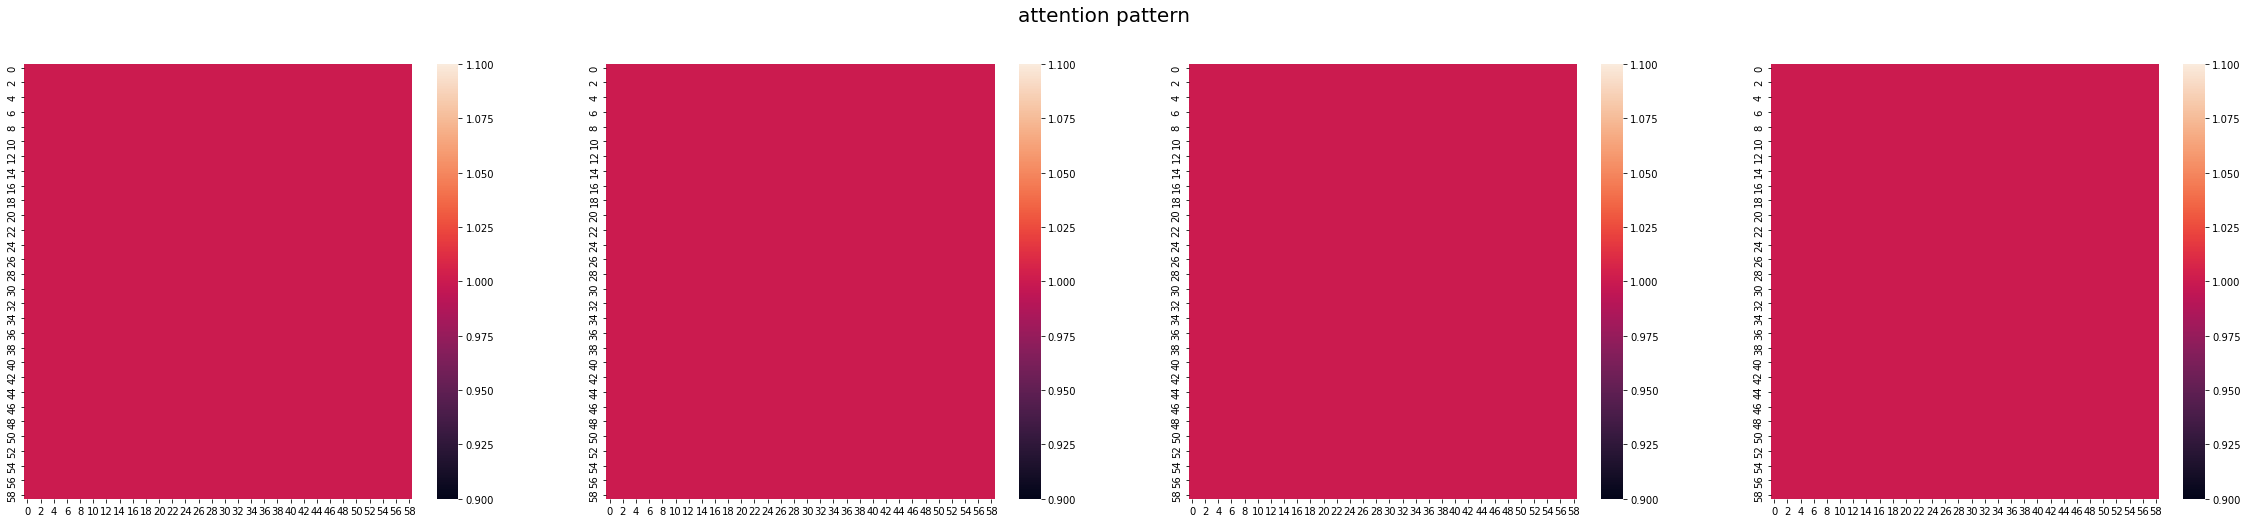

In [10]:
fig,ax=plt.subplots(1,4,figsize=(40,8))
fig.suptitle(f'attention pattern',fontsize=20)
for u in range(4):
    sns.heatmap((cached_attn[:,u,1,0].cpu().numpy().reshape(C,C)),ax=ax[u])

### Circle Isolation

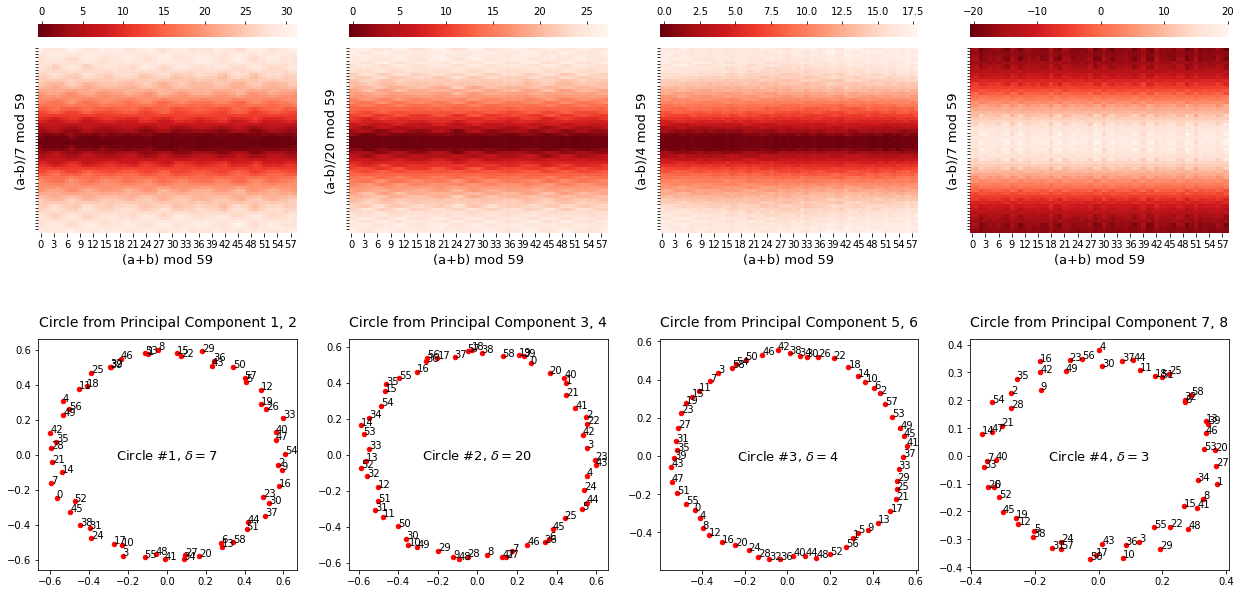

In [11]:
fig,ax=plt.subplots(2,4,figsize=(16/3*4,7/3*4))
ooo=[]
aa=[0,1,2,3,4,5,6,7] # put the desired dimensions here
for uu in range(0,8,2):
    model.load_state_dict(torch.load(model_file,map_location=DEVICE))
    # ok, now let's manipulate the embedding weights
    we=model.embed.W_E.T
    # now use scikit PCA to reduce the dimensionality of the embedding
    from sklearn.decomposition import PCA
    pca = PCA(n_components=20)
    we2=pca.fit_transform(we.detach().cpu().numpy())
    X=aa[uu]
    Y=aa[uu+1]
    ax1=ax[1,uu//2]
    box = ax1.get_position()
    box.y0-=0.09
    box.y1-=0.09
    ax1.set_position(box)
    ax[1,uu//2].set_title(f'Circle from Principal Component {X+1}, {Y+1}',fontsize=14,y=1.03)
    ax[1,uu//2].scatter(we2[:C,X],we2[:C,Y],c='r',s=20)
    for i in range(C):
        ax[1,uu//2].annotate(str(i), (we2[i,X],we2[i,Y]))
    we2[:,16:]=0
    for i in range(16):
        if i not in [X,Y]: we2[:,i]=0
    we3=pca.inverse_transform(we2)
    model.embed.W_E.data=torch.tensor(we3.T).to(model.embed.W_E.device)
    oo=[[0]*C for _ in range(C)]
    for x,y in dataloader:
        with torch.inference_mode():
            model.remove_all_hooks()
            #model.blocks[0].attn.hook_attn.add_hook(lambda x,name: cached_attn, 'fwd')
            model.eval()
            o=model(x)[:,-1,:]
            ox=o[list(range(len(x))),y]
            ox=ox.cpu()
            x=x.cpu()
            for r,q in zip(ox,x):
                q0=int(q[0].item())
                q1=int(q[1].item())
                #q0=(q0//2)+(q0%2)*((C+1)//2)
                oo[int(q0+C-q1)%C][(q0+q1)%C]=r.item()
    minn=(float('inf'),float('inf'))
    #rearr(np.array(oo),ax[1,uu//2])
    for t in range(1,C):
        means=[np.mean(oo[i*t%C]) for i in range(C)]
        mean_diffs_avg=np.mean([abs(means[i]-means[(i+1)%C]) for i in range(C)])
        minn=min(minn,(mean_diffs_avg,t))
    t=minn[1]
    if t>C-t:
        t=C-t
    ox=[oo[i*t%C] for i in range(C)]
    # use seaborn to plot the heatmap of oo
    import seaborn as sns
    # heatmap at ax[1,uu//2], all y ticks are on
    sns.heatmap(np.array(ox),ax=ax[0,uu//2],cmap='Reds_r', cbar_kws = dict(use_gridspec=False,location="top"))
    ooo.append(np.array(ox))
    ax[1,uu//2].annotate(f'Circle #{X//2+1}, $\delta=$'+str(t//2 if X>=6 else t),(0,0),ha='center',va='center',fontsize=13)
    # enable all y ticks
    ax[0,uu//2].set_yticks(np.arange(0,C,1))
    ax[0,uu//2].set_ylabel(f'(a-b)/{t} mod {C}',fontsize=13)
    ax[0,uu//2].set_xlabel(f'(a+b) mod {C}',fontsize=13)
#plt.tight_layout()
plt.savefig('correct_logit_iso2.svg',bbox_inches='tight')

### Logit FVE

In [12]:
import math
inv=lambda t:pow(t,C-2,C)
# need to plug in deltas here
wk=[2*math.pi/59*inv(7),2*math.pi/59*inv(20),2*math.pi/59*inv(4)]
for uu in range(3):
    print(f'Circle #{uu+1}')
    model.load_state_dict(torch.load(model_file,map_location=DEVICE))
    we=model.embed.W_E.T
    # now use scikit PCA to reduce the dimensionality of the embedding
    from sklearn.decomposition import PCA
    pca = PCA(n_components=20)
    we2=pca.fit_transform(we.detach().cpu().numpy())
    # modify dimension number here for different models
    X=uu*2
    Y=uu*2+1
    we2[:,16:]=0
    for i in range(16):
        if i not in [X,Y]: we2[:,i]=0
    we3=pca.inverse_transform(we2)
    model.embed.W_E.data=torch.tensor(we3.T).to(model.embed.W_E.device)
    ou=None
    for x,y in dataloader:
        with torch.inference_mode():
            model.remove_all_hooks()
            #model.blocks[0].attn.hook_attn.add_hook(lambda x,name: cached_attn, 'fwd')
            model.eval()
            o=model(x)[:,-1,:C]
            ou=o.reshape((C,C,C))
            #ou=o[list(range(len(x))),y].reshape((C,C))
            #ox=einops.repeat(ox,'a b->a b c',c=C)
            #ou=o.reshape((C,C,C))-ox
    oa=torch.zeros_like(ou,dtype=float)
    ob=torch.zeros_like(ou,dtype=float)
    oc=torch.zeros_like(ou,dtype=float)
    for i in range(C):
        for j in range(C):
            for k in range(C):
                from math import sin,cos
                oa[i][j][k]=cos(wk[uu]*(i+j-k))
                s=(cos(wk[uu]*i)+cos(wk[uu]*j),sin(wk[uu]*i)+sin(wk[uu]*j))
                co,si=cos(wk[uu]*k/2),sin(wk[uu]*k/2)
                ob[i][j][k]=abs(co*s[0]+si*s[1])-abs(-si*s[0]+co*s[1])
                g=(cos(wk[uu]*i-math.pi/4)+cos(wk[uu]*j-math.pi/4),sin(wk[uu]*i-math.pi/4)+sin(wk[uu]*j-math.pi/4))
                o0=(abs(s[0])-abs(s[1]))*math.cos(wk[uu]*k)+(abs(g[0])-abs(g[1]))*math.sin(wk[uu]*k)
                ci=cos(wk[uu]*i)
                cj=cos(wk[uu]*j)
                si=sin(wk[uu]*i)
                sj=sin(wk[uu]*j)
                o1=(abs(ci+cj)-abs(si+sj))*math.cos(wk[uu]*k)-(abs(ci+cj-si-sj)-abs(ci+cj+si+sj))*math.sin(wk[uu]*k)*(2**(-0.5))
                oc[i][j][k]=o1
    #ob=oa
    def npfy(x,n=False):
        try:
            x=x.detach()
        except:
            pass
        try:
            x=x.cpu()
        except:
            pass
        try:
            x=x.numpy()
        except:
            pass
        try:
            x=np.array(x)
        except:
            pass
        if n:
            x=(x-np.mean(x))/np.std(x)
        return x
    import sklearn
    pa=(sklearn.metrics.explained_variance_score(npfy(ou,1).flatten(),npfy(oa,1).flatten()))
    pb=(sklearn.metrics.explained_variance_score(npfy(ou,1).flatten(),npfy(ob,1).flatten()))
    pc=(sklearn.metrics.explained_variance_score(npfy(ou,1).flatten(),npfy(oc,1).flatten()))
    print("Qclock & Qpizza & Qpizza' (appendix)")
    print(f'{pa*100:.2f}% & {pb*100:.2f}% & {pc*100:.2f}%')

Circle #1
Qclock & Qpizza & Qpizza' (appendix)
75.41% & 98.31% & 98.36%
Circle #2
Qclock & Qpizza & Qpizza' (appendix)
75.62% & 98.31% & 98.30%
Circle #3
Qclock & Qpizza & Qpizza' (appendix)
75.38% & 98.41% & 98.61%


### Accompanying Pizza Logit FVE

In [13]:
import math
inv=lambda t:pow(t,C-2,C)
# need to plug in deltas here
wk=[0,0,0,2*math.pi/59*inv(7),2*math.pi/59*inv(20),2*math.pi/59*inv(4)]
for uu in range(3,6):
    print(f'Circle #{uu+1}')
    model.load_state_dict(torch.load(model_file,map_location=DEVICE))
    we=model.embed.W_E.T
    # now use scikit PCA to reduce the dimensionality of the embedding
    from sklearn.decomposition import PCA
    pca = PCA(n_components=20)
    we2=pca.fit_transform(we.detach().cpu().numpy())
    # modify dimension number here for different models
    X=uu*2
    Y=uu*2+1
    we2[:,16:]=0
    for i in range(16):
        if i not in [X,Y]: we2[:,i]=0
    we3=pca.inverse_transform(we2)
    model.embed.W_E.data=torch.tensor(we3.T).to(model.embed.W_E.device)
    ou=None
    for x,y in dataloader:
        with torch.inference_mode():
            model.remove_all_hooks()
            #model.blocks[0].attn.hook_attn.add_hook(lambda x,name: cached_attn, 'fwd')
            model.eval()
            o=model(x)[:,-1,:C]
            ou=o.reshape((C,C,C))
            #ou=o[list(range(len(x))),y].reshape((C,C))
            #ox=einops.repeat(ox,'a b->a b c',c=C)
            #ou=o.reshape((C,C,C))-ox
    oa=torch.zeros_like(ou,dtype=float)
    for i in range(C):
        for j in range(C):
            for k in range(C):
                from math import sin,cos
                s=(cos(2*wk[uu]*i)+cos(2*wk[uu]*j),sin(2*wk[uu]*i)+sin(2*wk[uu]*j))
                co,si=cos(wk[uu]*k),sin(wk[uu]*k)
                oa[i][j][k]=-(co*s[0]+si*s[1])
    #ob=oa
    def npfy(x,n=False):
        try:
            x=x.detach()
        except:
            pass
        try:
            x=x.cpu()
        except:
            pass
        try:
            x=x.numpy()
        except:
            pass
        try:
            x=np.array(x)
        except:
            pass
        if n:
            x=(x-np.mean(x))/np.std(x)
        return x
    import sklearn
    pa=(sklearn.metrics.explained_variance_score(npfy(ou,1).flatten(),npfy(oa,1).flatten()))
    print("Qpizzaacomp")
    print(f'{pa*100:.2f}%')
    #break

Circle #4
Qpizzaacomp
97.56%
Circle #5
Qpizzaacomp
97.23%
Circle #6
Qpizzaacomp
97.69%


### 2D PCA Visualizations

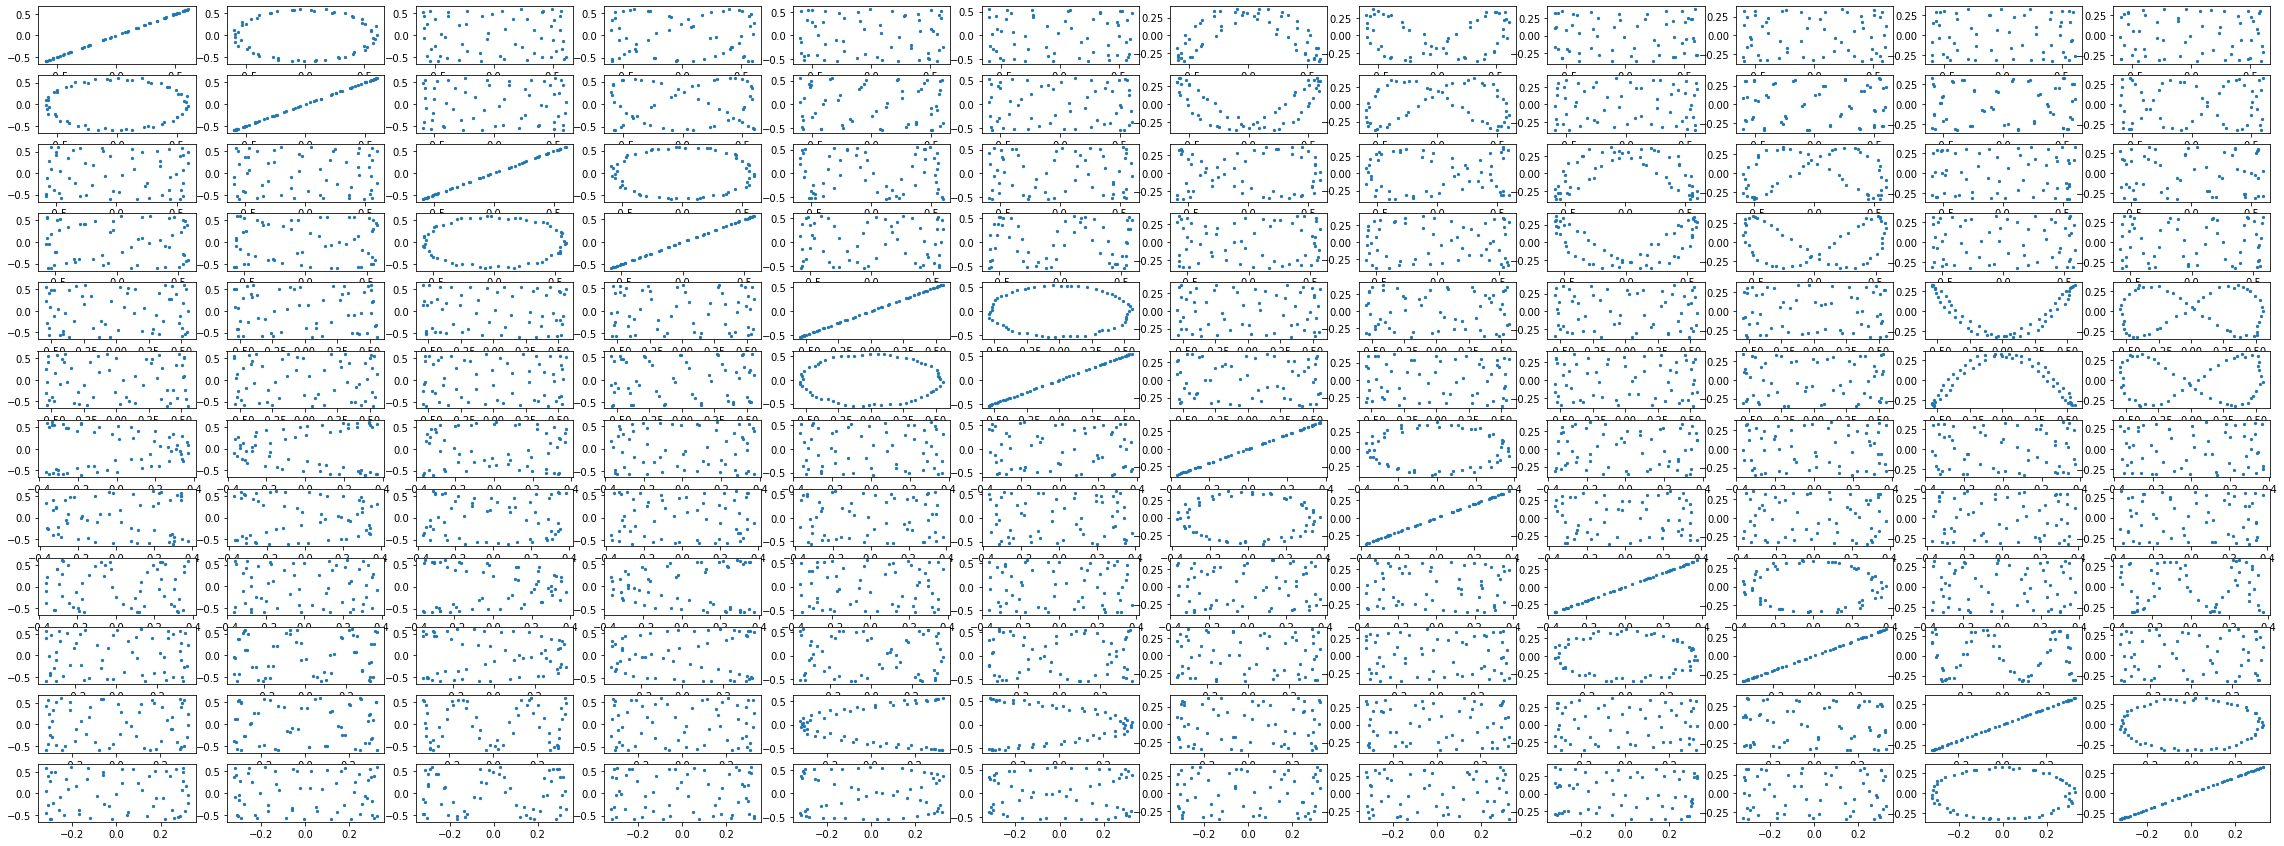

In [14]:
fig,ax=plt.subplots(12,12,figsize=(40,15))
model.load_state_dict(torch.load(model_file,map_location=DEVICE))
we=model.embed.W_E.T
# now use scikit PCA to reduce the dimensionality of the embedding
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
we2=pca.fit_transform(we.detach().cpu().numpy())
for i in range(12):
    for j in range(12):
        ax[i,j].scatter(we2[:,i],we2[:,j],s=5)